In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML, Image

This summarizes notes and simple demonstrative implementation regarding policy gradient methods based on the following three papers:

1. [Policy Gradient Methods for Reinforcement Learning with Function Approximation](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) Sutton '99
2. [Deterministic Poicy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf) Silver '14
3. [Continuous Control with Deep Reinforcement Learning](https://arxiv.org/pdf/1509.02971.pdf) Lillicrap '16

Helpful notes:
- [Policy Gradients in a Nutshell](https://www.sanyamkapoor.com/machine-learning/policy-gradients-nutshell/)
- [Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)
- [Notes on policy gradients and the log derivative trick for reinforcement learning](http://www.1-4-5.net/~dmm/ml/log_derivative_trick.pdf) (has some errors, but some good high-level notes
- [Machine Learning Trick of the day: Log-Derivative](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/)

# "Policy Gradient Methods for Reinforcement Learning with Function Approximation" - Sutton, McAllester, Singh & Mansour 1999
- O.G. policy gradient theorem
- REINFORCE and actor-critic methods are special cases
- main new result is to show that the gradient can be written in a form suitable for estimation from experience aided by an approximate action-value or advantage function.
- proves that a version of policy iteration with arbitrary differentiable function approximation is convergent to a locally optimal policy

- value fn. estimation (eg Q learning) implicitly encodes the optimal policy as the greedy policy wrt. estimated q-values. Undesierable properties:
    - oriented towards deterministic policies (stochastic policies are often optimal; eg: when playing games)
    - arbitrarly small differences in estimated action values can cause them to remain unselected
    - Q-Iearning, Sarsa, and dynamic programming methods have all been shown unable to converge to any policy for simple MDPs and simple function approximators (asymptotically, theoretical result; all work in practice for some problems, though there are contrived counter examples)

### Log-Derivative Trick
Bit of a diversion, but necessary for deriving PG. PG thm. may be viewed as simple applications of calc & probability rules;
One identity that tripped me up at bit was the log-derivative trick; a simple identity for gradient wrt. params $\theta$ of the log of a function $p(x;\theta)$.

<center>
    $\nabla_\theta log p(x;\theta) = \frac{\nabla_\theta p(x;\theta)}{p(x;\theta)}$
</center>

This is not too hard to illustrate:

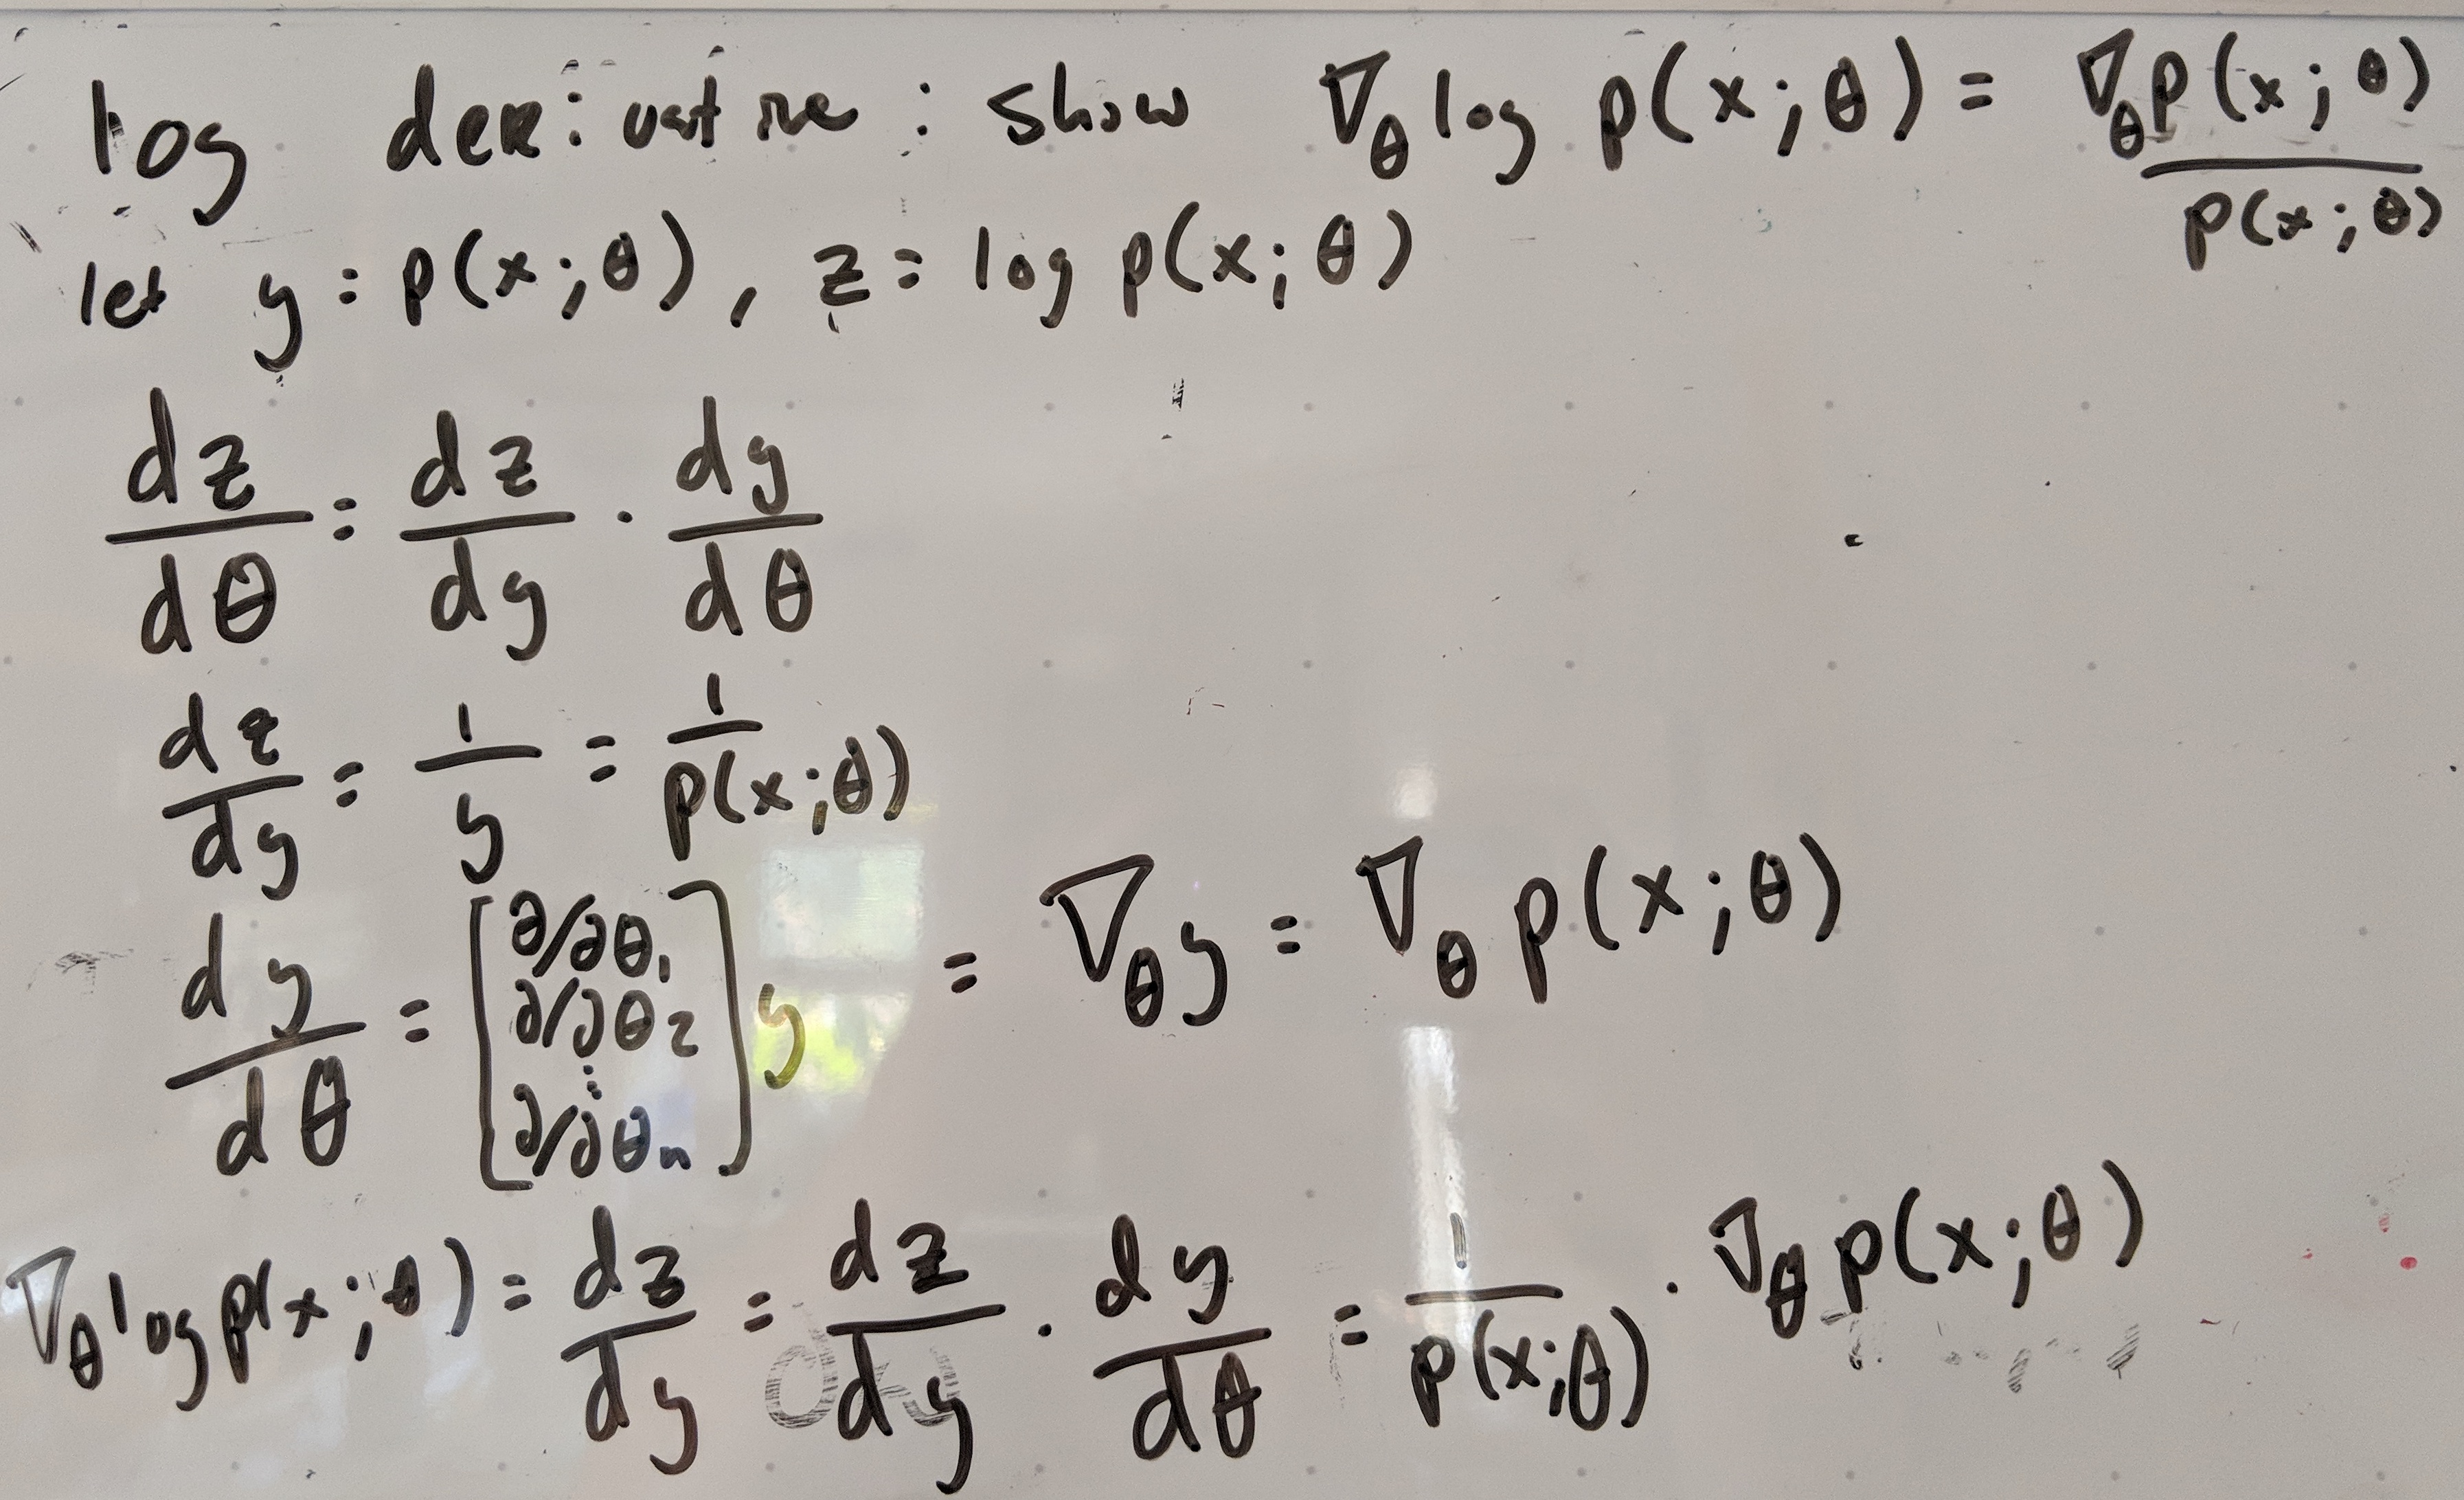

In [4]:
Image(filename="log_deriv.jpg")

In the case where $p(x;\theta)$ is a [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function), $\nabla_\theta log p(x;\theta)$ is referred to as a [score](https://en.wikipedia.org/wiki/Score_(statistics) which, intuitively, measures the sensitivity of the likelihood function to its parameter $\theta$.

I frequently referenced [ML trick of the day: Log Derivative Trick](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/) which made the derivation of policy gradients much more straightforward:

__Warmup__: Messing around with this a bit, we can show the expected value of the score is zero:

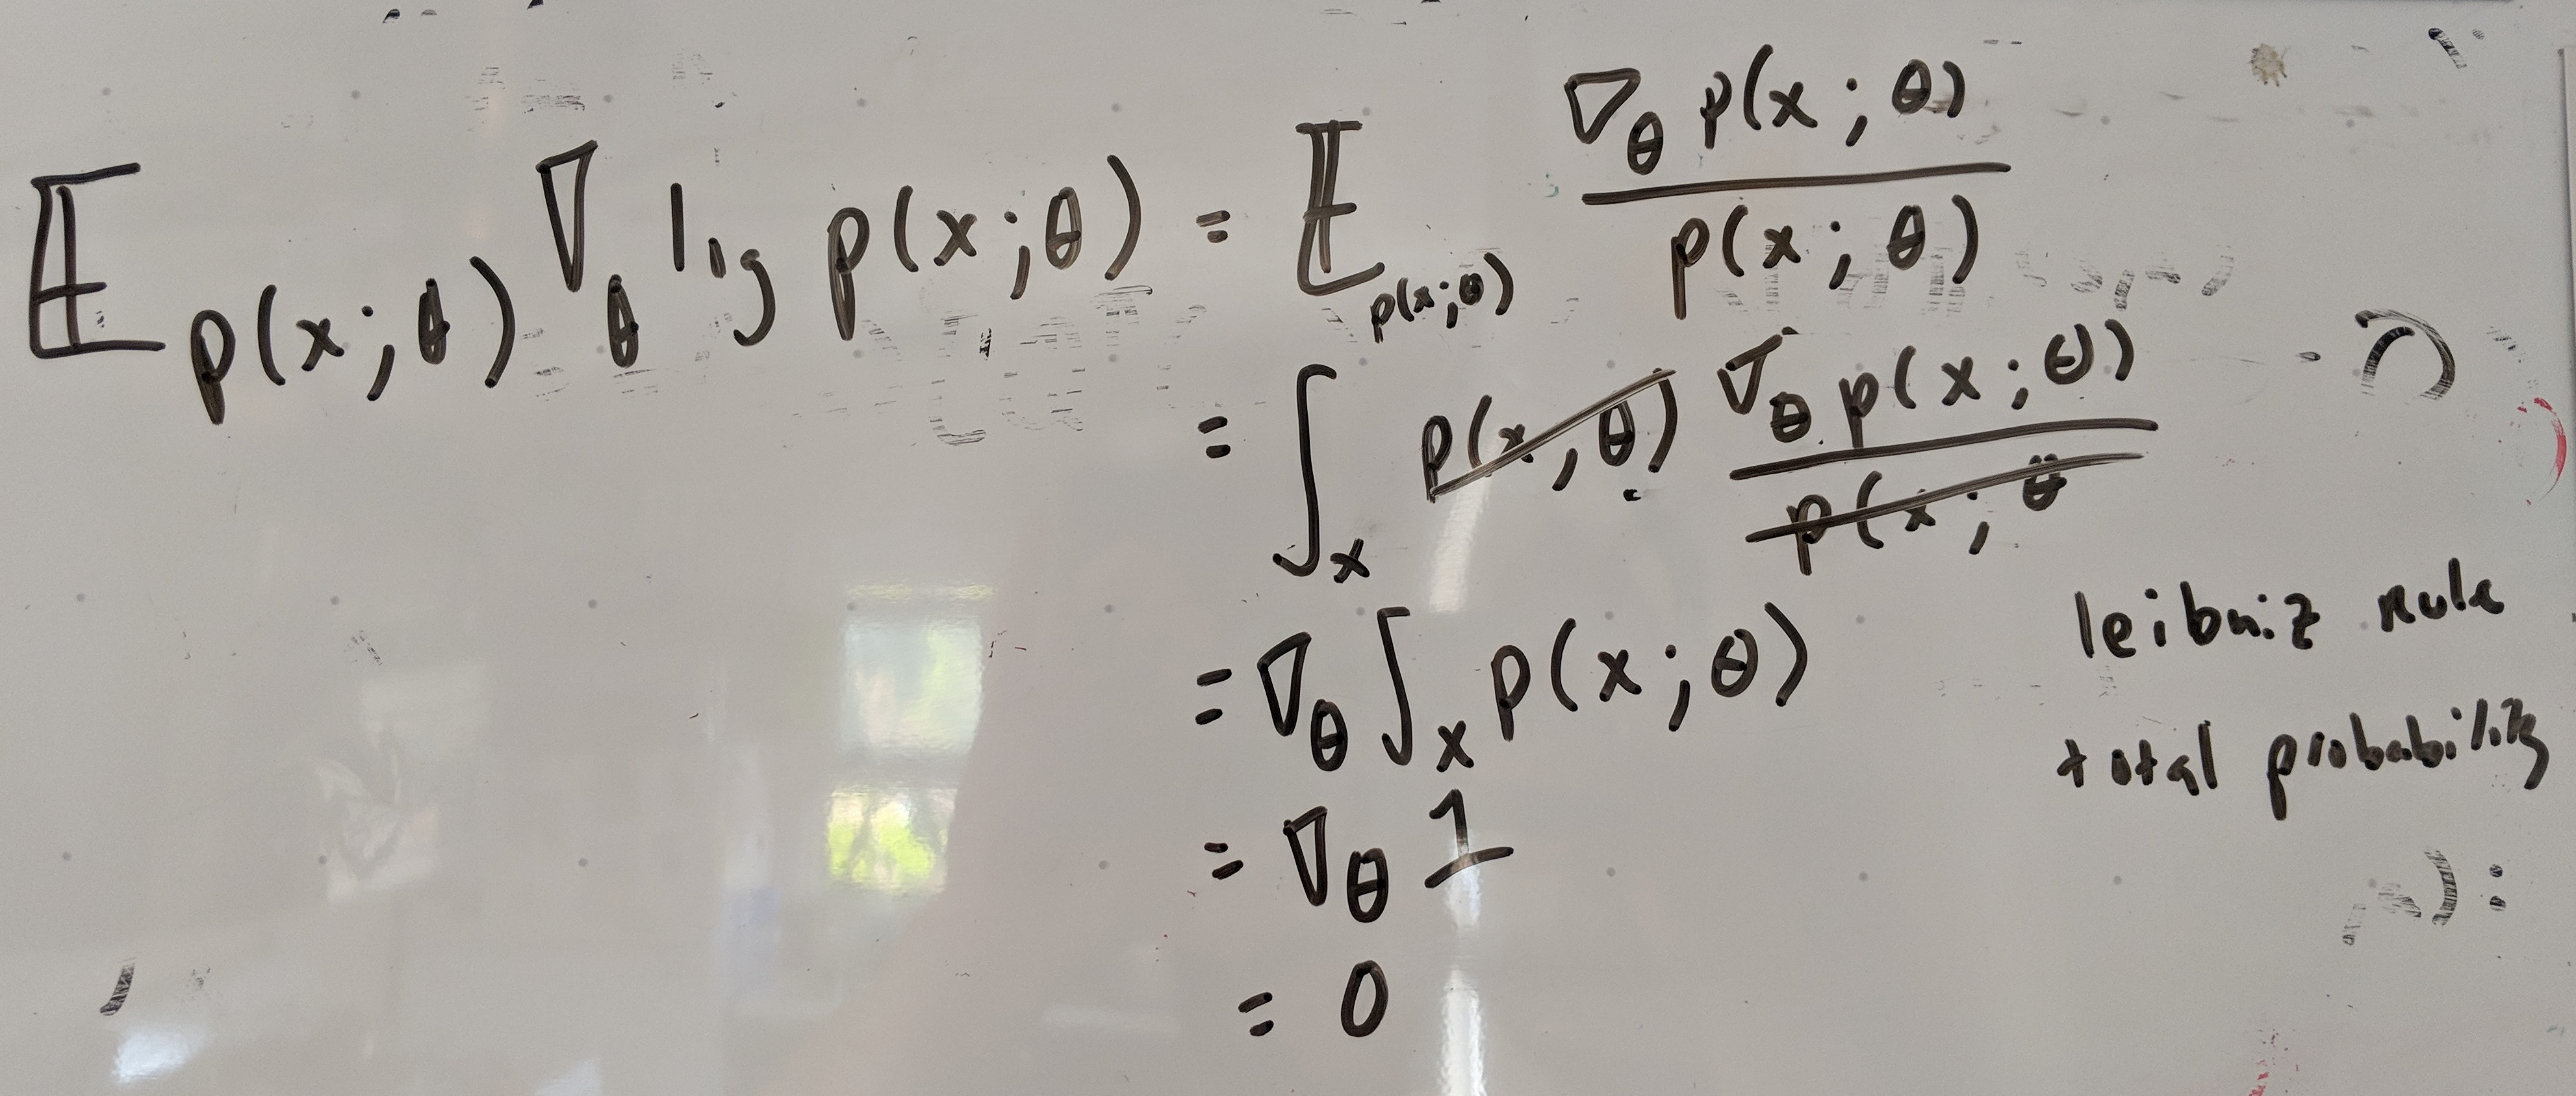

In [3]:
Image(filename="expectation_of_score.jpg")

### Score function estimators w/ log deriv.

Now to the task at hand: for PG we will need to compute the gradient of an expectation of a function:
<center>
    $\nabla_\theta \mathbb{E}_{p(x;\theta)}[f(x)] = \mathbb{E}_{p(x;\theta)}[f(x)\nabla_\theta log p(x;\theta)]$
</center>

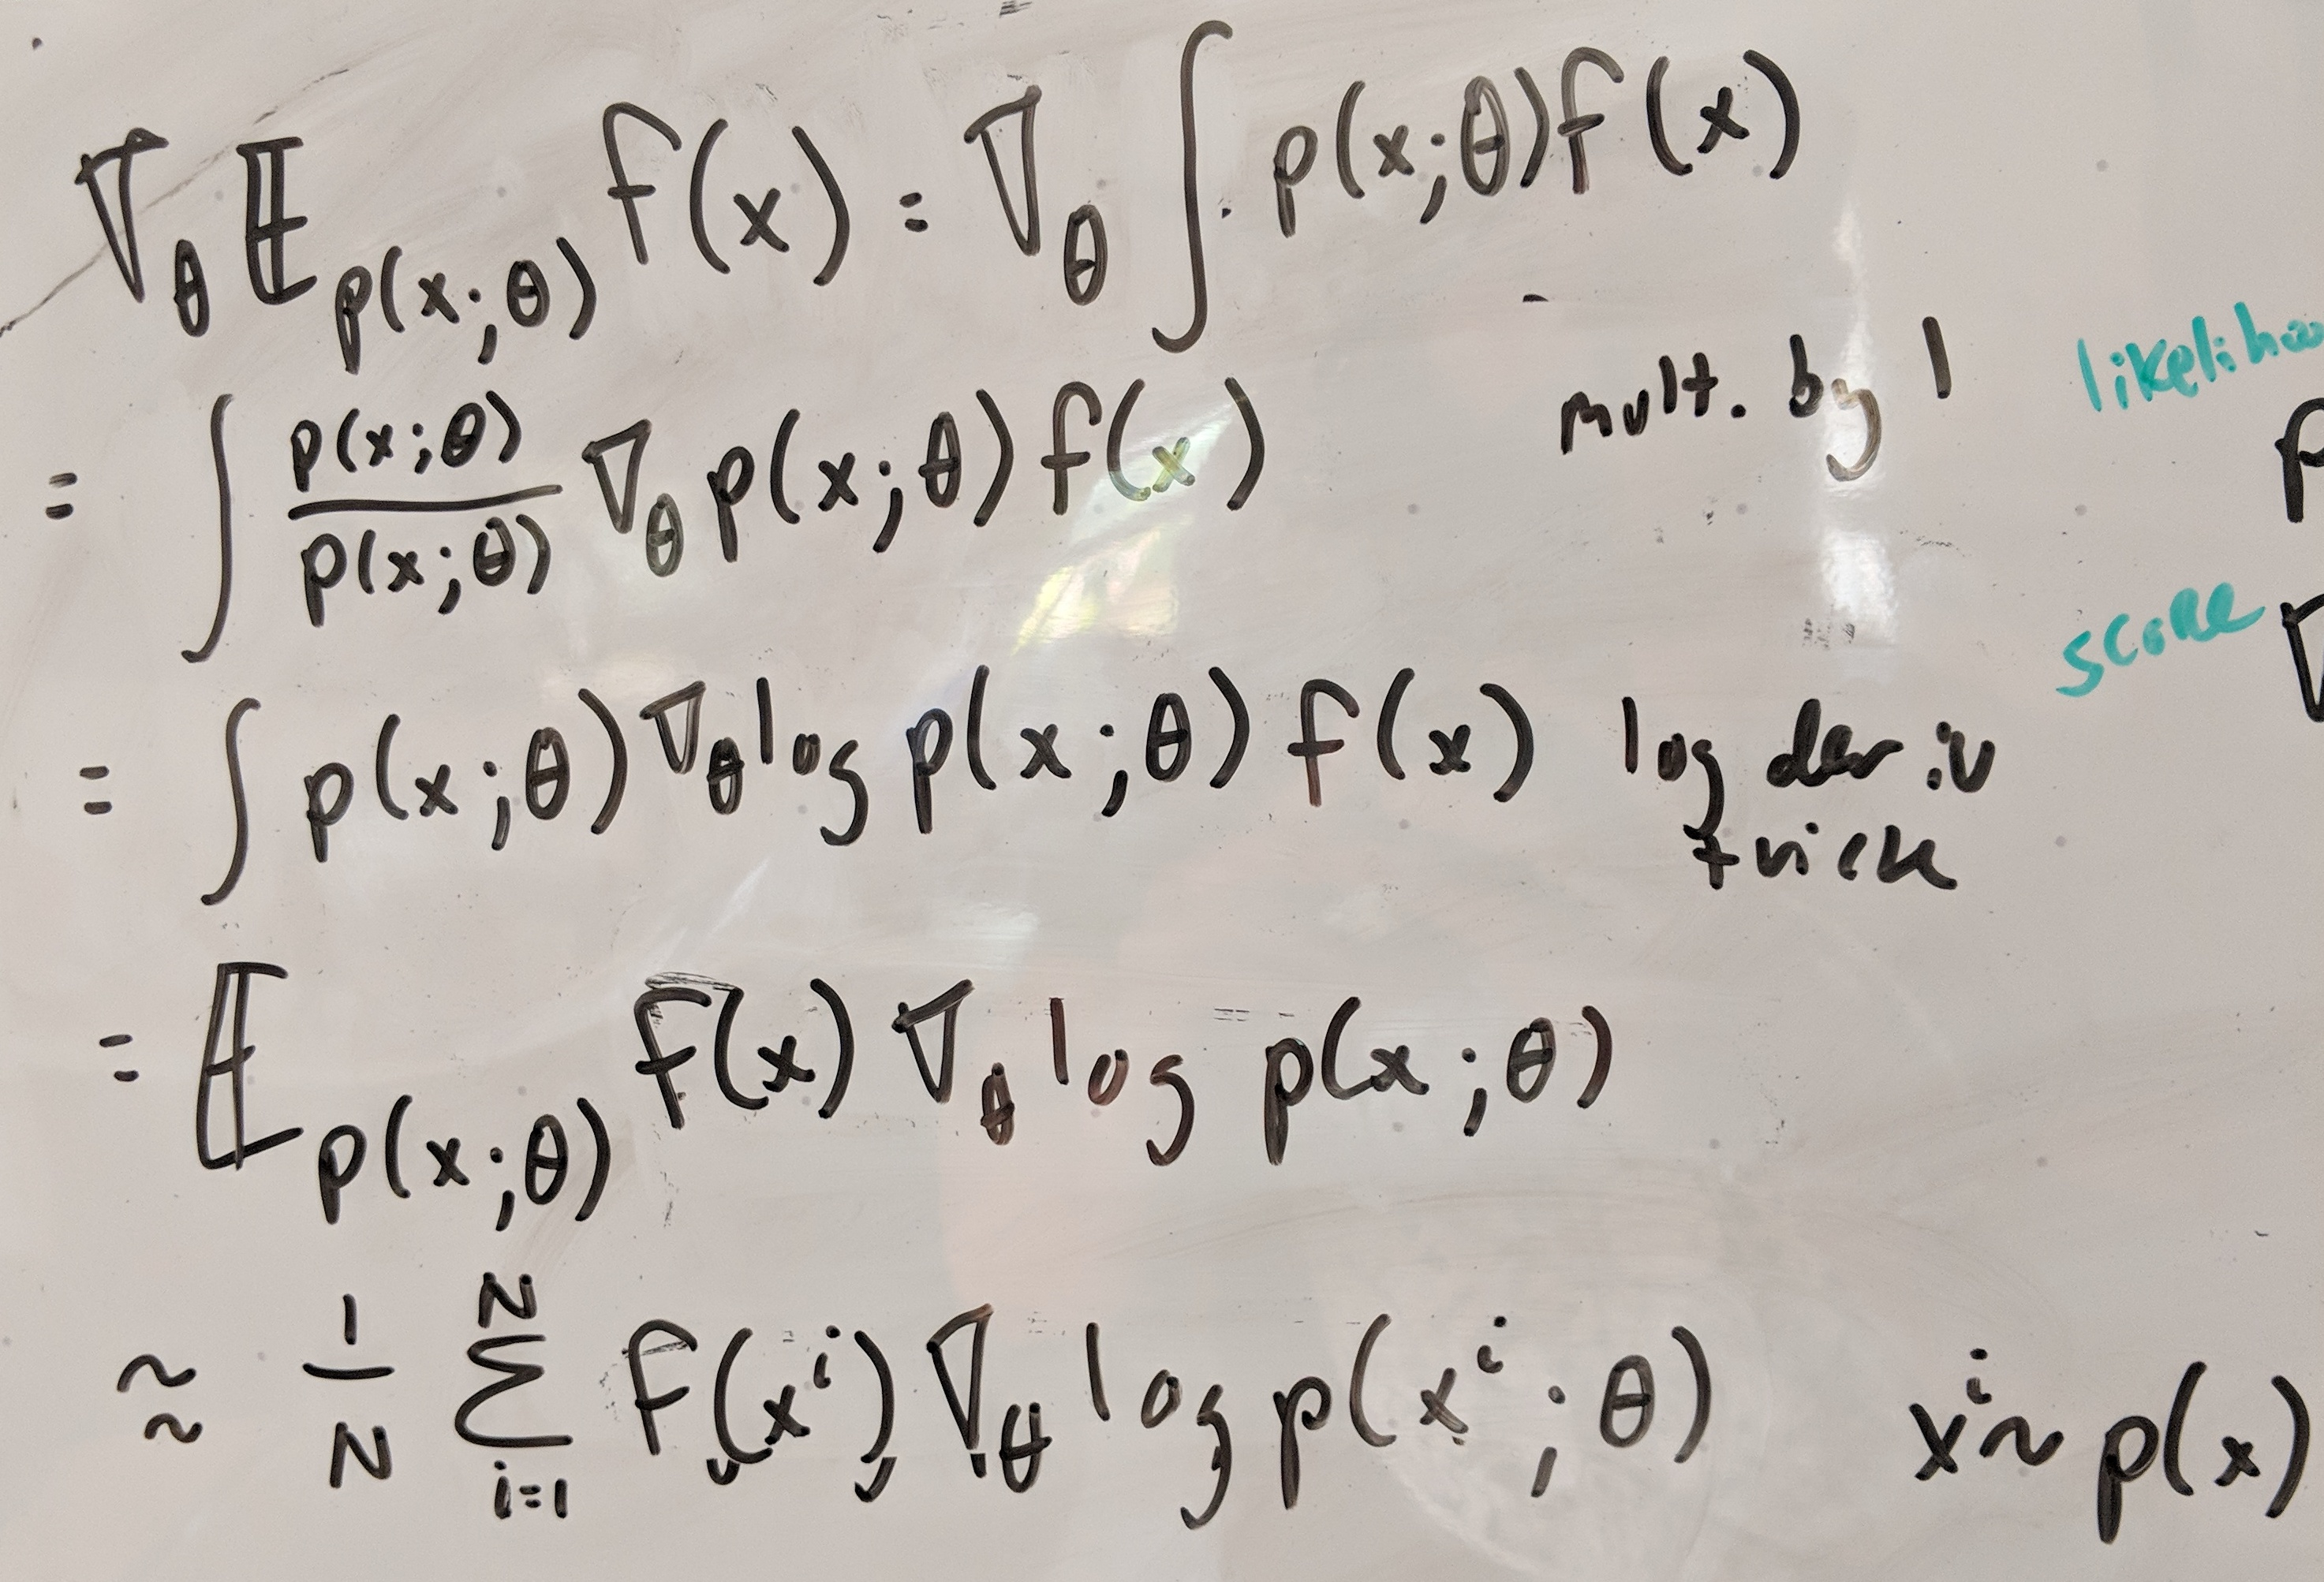

In [5]:
Image(filename="score_estimator.jpg")

I needed to see this visually, here is a quick and dirty SGD implementation using above score function estimator to find parameters $\mu, \sigma$ of a gaussian $p(x;\mu,\sigma)$ minimizes a convex function 

In [7]:
def normal(mu, sig):
    def f(x):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    return f

def grad_normal(mu, sig):
    def f(x):
        df_dmu = normal(mu, sig)(x) * (x - mu) / (sig ** 2)
        df_dsig = normal(mu, sig)(x) * ((x - mu) ** 2) / (sig ** 3)
        return np.array([df_dmu, df_dsig])
    return f

def objective(a, b):
    def f(x):
        return a * x ** 2 + b
    return f

In [8]:
f = objective(.25, .5)

mu = [3.]
sigma = [2.]

n_iter = 200
N = 25          # num samples used to estimate the gradient
alpha = .05      # learning rate
sigma_min = .2

for i in range(n_iter):
    p = normal(mu[-1], sigma[-1])
    grad_p = grad_normal(mu[-1], sigma[-1])
    
    # score function estimator
    sample = []
    for _ in range(N):
        x = np.random.normal(mu[-1], sigma[-1])
        
        # uses the log deriviative trick
        grad_log_p = grad_p(x) / p(x)
        sample.append(f(x) * grad_log_p)
    
    # average the gradients and update parameters
    grads = np.mean(np.array(sample), axis=0)
    mu.append(mu[-1] - alpha * grads[0])
    sigma.append(sigma[-1] - alpha * .25 * grads[1])
    if sigma[-1] < sigma_min:
        sigma[-1] = sigma_min

In [9]:
x = np.linspace(-3,3)

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
p = normal(mu[0], sigma[0])
grad_p = grad_normal(mu[0], sigma[0])

f_plot, = ax[0].plot(x, f(x), color='black', label="$f(x)$")
p_plot, = ax[0].plot(x, p(x), color='red', label="$p(x)$")
ax[0].fill_between(x, p(x) * f(x), alpha=.2, color='blue', label="$\int p(x)f(x)$")
ax[0].scatter(mu[0], f(mu[0]), color='red')

f2_plot, = ax[1].plot(x, f(x), color='black', label="$f(x)$")
p2_plot, = ax[1].plot(x, p(x), color='red', label="$p(x)$")
ax[1].fill_between(x, -p(x) * f(x) * grad_p(x)[0], alpha=.2, color='blue', label="$\int p(x)f(x) \partial_\mu log p(x)$")
mu_grad_line, = ax[1].plot(x, -grad_p(x)[0] / p(x), color='green', label="$\partial_\mu log p(x)$")
sigma_grad_line, = ax[1].plot(x, -grad_p(x)[1] / p(x), color='blue', label="$\partial_\sigma log p(x)$")
ax[1].scatter(mu[0], f(mu[0]), color='red')

ax[0].set_ylim((-1., 2.))
ax[0].set_xlabel("X")
ax[1].set_xlabel("X")

_=ax[0].legend()
_=ax[1].legend()
plt.close() # hides the initialized figure

# initialization function: plot the background of each frame
def init():
    f_plot.set_data(x, f(x))
    return (f_plot,p_plot,p2_plot)

# animation function. This is called sequentially
def animate(i):
    p = normal(mu[i], sigma[i])
    grad_p = grad_normal(mu[i], sigma[i])
    
    p_plot.set_data(x, p(x))
    ax[0].collections.clear()
    ax[0].fill_between(x, p(x) * f(x), alpha=.2, color='blue', label="$\int p(x)f(x)$")
    ax[0].scatter(mu[i], f(mu[i]), color='red')
    
    p2_plot.set_data(x, p(x))
    mu_grad_line.set_data(x, - grad_p(x)[0] / p(x))
    sigma_grad_line.set_data(x, - grad_p(x)[1] / p(x))
    ax[1].collections.clear()
    ax[1].fill_between(x, -p(x) * f(x) * grad_p(x)[0], alpha=.2, color='blue',
                       label="$\int p(x)f(x) \partial_\mu log p(x)$")
    ax[1].scatter(mu[i], f(mu[i]), color='red')
    
    
    return (f_plot,p_plot,p2_plot)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(mu), interval=50, blit=True)

HTML("<center>{}</center>".format(anim.to_html5_video()))

### Back to policy gradients

A primary insight for me was to take this more general case and specialize it to reinforcement learning & policy gradients. All we need to do is keep telling ourselves that:

1. $f$ is some value function: actual return $R_t$ in the Monte-Carlo / REINFORCE case or some estimator $Q(s,a)$ or $V(a)$
2. the likelihood $p(x;\theta)$ becomes a stochastic policy $\pi(s,a;\theta)$ or in some notations $\pi_{\theta}(s,a)$
3. the score / fisher information $\nabla_\theta log p(x;\theta)$ becomes the policy gradient $\nabla_\theta log \pi_{\theta}(s,a)$

__Main Idea:__ We are interested in finding the gradient (how we should shift the distribution $\pi$ through its parameters $θ$) to increase the scores of its samples (as judged by $f$)

Karpathy's notes (simplified form of the above derivation):

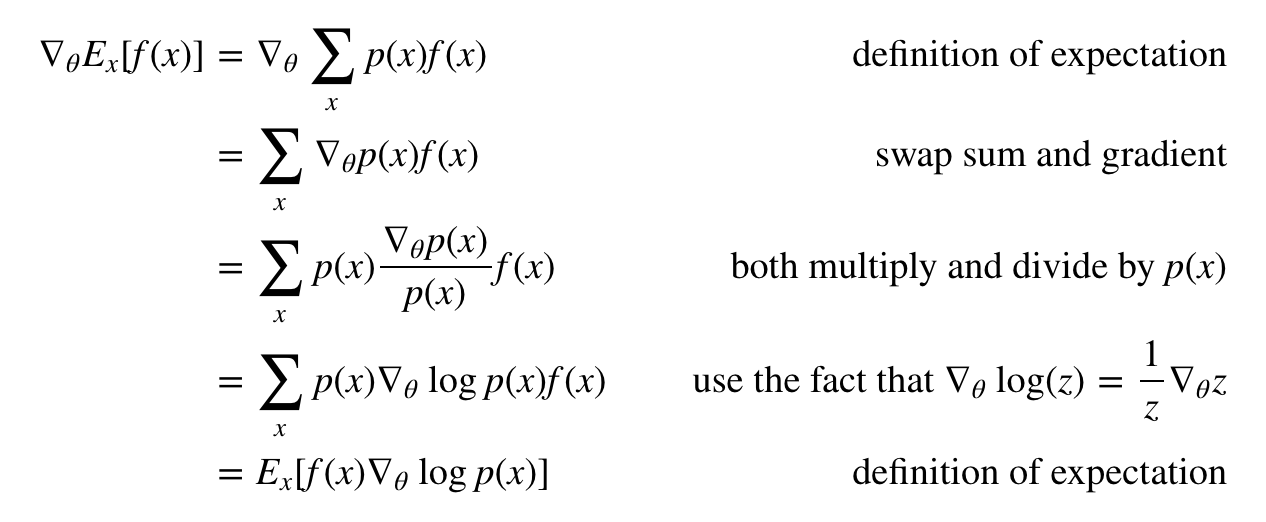

In [8]:
Image(filename="ak_pg.png")